DRKG

Adapted from: https://github.com/gnn4dr/DRKG/blob/master/drkg_with_dgl/loading_drkg_in_dgl.ipynb

In [1]:
import pandas as pd
import numpy as np
import os 
import torch_geometric.transforms as T
import torch
from sklearn.metrics import accuracy_score

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric as pyg
import torch_geometric
from torch_geometric.nn import SAGEConv, to_hetero
from   torch.utils.data      import Dataset, DataLoader
from   torch_geometric.data  import Data
from   torch_geometric.utils import negative_sampling


from torch_geometric.nn           import SAGEConv, to_hetero
from SIMP_LLM.dataloader_mappings import load_graph,load_csv_as_list


from SIMP_LLM.models              import  GATStack,GNNStack,LinkPredictorMLP,CosineSimilarityModel,save_torch_model
from SIMP_LLM.train_utils         import  forward_pass, train,evaluate,   filter_edge_index_by_value,split_edge_index,get_negative_edges

import matplotlib.pyplot as plt #needed to visualize loss curves
import numpy as np 

from sklearn         import metrics
from sklearn.metrics import ConfusionMatrixDisplay


import copy

/opt/conda/envs/simp/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import json

def load_dictionary(file_path):
    try:
        with open(file_path, 'r') as file:
            dictionary = json.load(file)
        return dictionary
    except FileNotFoundError:
        print("File not found.")
        return None
    except json.JSONDecodeError:
        print("Invalid JSON format.")
        return None

def save_dictionary(dictionary, file_path):
    def default_handler(obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        raise TypeError('Object of type {} is not JSON serializable'.format(type(obj)))
    
    try:
        with open(file_path, 'w') as file:
            json.dump(dictionary, file, default=default_handler)
        print("Dictionary saved successfully.")
    except Exception as e:
        print("Error saving dictionary:", str(e))

## Load Graph

In [3]:
#triplets =[('Compound', 'Compound_treats_the_disease', 'Disease')] # Uncomment this line 
triplets     = load_csv_as_list('triplets.csv')                     # triplets of form (tail, relationship,head)
data         = load_graph(triplets )                                # Load Graph based on triplets (You can selet the triplets 
dictionaries = torch.load("data2/mapping_dict")
#print(data)
#print(data["Compound", "Compound_treats_the_disease", "Disease"].edge_index)

data2


## GRAPH SAGE

#### 1 Masking Sanity Check

In [4]:
edge_index = torch.tensor([[0, 0, 0, 1, 1, 2, 2, 3,4,5,5,5,5,5], [1, 2, 3, 4, 5, 6, 7, 8,9,10,11,12,13,14]])
print(f"Oringal Edge index:\n{edge_index }\n: {edge_index.shape}\n")
edge_index_1 , edge_index_2 = split_edge_index(edge_index ,percentage = 0.5,verbose=True)

Oringal Edge index:
tensor([[ 0,  0,  0,  1,  1,  2,  2,  3,  4,  5,  5,  5,  5,  5],
        [ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]])
: torch.Size([2, 14])

##############
Edge Index 1: torch.Size([2, 5])

Edge Index 2: torch.Size([2, 9])
##############


### 2 Mask Real Data 

In [5]:
## SPLIT TRAIN, TEST, VAL
edge_index_train , edge_index_validation_test          = split_edge_index(edge_index = data["Compound", "Compound_treats_the_disease", "Disease"].edge_index ,percentage = 0.9,verbose=True)
edge_index_validation ,edge_index_test                 = split_edge_index(edge_index = edge_index_validation_test  ,percentage = 0.5,verbose=True)


## Furthere split into EMBED and PREDICT for every split ###
edge_index_train_embed , edge_index_train_predict      = split_edge_index(edge_index = edge_index_train ,percentage = 0.8,verbose=True)
edge_index_val_embed   , edge_index_val_predict        = split_edge_index(edge_index = edge_index_validation   ,percentage = 0.85,verbose=True)
edge_index_test_embed  , edge_index_test_predict       = split_edge_index(edge_index = edge_index_validation   ,percentage = 0.85,verbose=True)





### Train ###
data_train_embed = copy.deepcopy(data)
data_train_embed["Compound", "Compound_treats_the_disease", "Disease"].edge_index = edge_index_train_embed
print(data_train_embed["Compound", "Compound_treats_the_disease", "Disease"].edge_index.shape)

data_train_predict = copy.deepcopy(data)
data_train_predict["Compound", "Compound_treats_the_disease", "Disease"].edge_index = edge_index_train_predict 
print(data_train_predict["Compound", "Compound_treats_the_disease", "Disease"].edge_index.shape)

### Val ###
data_val_embed = copy.deepcopy(data)
data_val_embed["Compound", "Compound_treats_the_disease", "Disease"].edge_index = edge_index_val_embed 
print(data_val_embed["Compound", "Compound_treats_the_disease", "Disease"].edge_index.shape)

data_val_predict = copy.deepcopy(data)
data_val_predict["Compound", "Compound_treats_the_disease", "Disease"].edge_index = edge_index_val_predict
print(data_val_predict["Compound", "Compound_treats_the_disease", "Disease"].edge_index.shape)



### Test ###
data_test_embed = copy.deepcopy(data)
data_test_embed["Compound", "Compound_treats_the_disease", "Disease"].edge_index = edge_index_test_embed 
print(data_test_embed["Compound", "Compound_treats_the_disease", "Disease"].edge_index.shape)

data_test_predict = copy.deepcopy(data)
data_test_predict["Compound", "Compound_treats_the_disease", "Disease"].edge_index = edge_index_test_predict
print(data_test_predict["Compound", "Compound_treats_the_disease", "Disease"].edge_index.shape)




##############
Edge Index 1: torch.Size([2, 40666])

Edge Index 2: torch.Size([2, 7888])
##############
##############
Edge Index 1: torch.Size([2, 1969])

Edge Index 2: torch.Size([2, 5919])
##############
##############
Edge Index 1: torch.Size([2, 30998])

Edge Index 2: torch.Size([2, 9668])
##############
##############
Edge Index 1: torch.Size([2, 972])

Edge Index 2: torch.Size([2, 997])
##############
##############
Edge Index 1: torch.Size([2, 972])

Edge Index 2: torch.Size([2, 997])
##############
torch.Size([2, 30998])
torch.Size([2, 9668])
torch.Size([2, 972])
torch.Size([2, 997])
torch.Size([2, 972])
torch.Size([2, 997])


###  3 Compile Model 

In [122]:
epochs        = 60 
hidden_dim    = 524      
dropout       = 0.7
num_layers    = 3
learning_rate = 1e-4
node_emb_dim  = 768
device        = "cpu"
head          = "COSINE"    # one of   "MLP", "COSINE"
backbone      = "GraphSage" # one of  "GraphSage","GAT"
Triplet_loss  = True 
Margin        = 2.0


#GATStack,GNNStack


if backbone == "GraphSage":
    HomoGNN         = GNNStack(node_emb_dim, hidden_dim, hidden_dim, num_layers, dropout, return_embedding=True).to(device) # the graph neural network that takes all the node embeddings as inputs to message pass and agregate
elif backbone == "GAT":
    HomoGNN         = GATStack(node_emb_dim, hidden_dim, hidden_dim, num_layers, dropout, return_embedding=True).to(device) 
    
embed_model     = to_hetero(HomoGNN   , data.metadata(), aggr='sum')
if head == "MLP":
    link_predictor  = LinkPredictorMLP(hidden_dim, hidden_dim, 1, num_layers , dropout).to(device) # the MLP that takes embeddings of a pair of nodes and predicts the existence of an edge between them
if head == "COSINE":
    link_predictor = CosineSimilarityModel(input_dim=524 ).to(device)

#optimizer      = torch.optim.AdamW(list(model.parameters()) + list(link_predictor.parameters() ), lr=learning_rate, weight_decay=1e-4)
if head ==  "MLP":
    optimizer       = torch.optim.Adam(list(embed_model.parameters()) + list(link_predictor.parameters() ), lr=learning_rate)
elif head == "COSINE":
    optimizer       = torch.optim.Adam(list(embed_model.parameters()) , lr=learning_rate)
    

#print(HeteroGNN )
print(link_predictor)
print(f"Models Loaded to {device}")
data.to(device)
embed_model.to(device)
print()

/opt/conda/envs/simp/lib/python3.11/site-packages/torch_geometric/nn/to_hetero_transformer.py:165: UserWarning: The type 'Side Effect' contains invalid characters which may lead to unexpected behavior. To avoid any issues, ensure that your types only contain letters, numbers and underscores.
  warnings.warn(
/opt/conda/envs/simp/lib/python3.11/site-packages/torch_geometric/nn/to_hetero_transformer.py:165: UserWarning: The type 'Biological Process' contains invalid characters which may lead to unexpected behavior. To avoid any issues, ensure that your types only contain letters, numbers and underscores.
  warnings.warn(
/opt/conda/envs/simp/lib/python3.11/site-packages/torch_geometric/nn/to_hetero_transformer.py:165: UserWarning: The type 'Cellular Component' contains invalid characters which may lead to unexpected behavior. To avoid any issues, ensure that your types only contain letters, numbers and underscores.
  warnings.warn(
/opt/conda/envs/simp/lib/python3.11/site-packages/torch_

CosineSimilarityModel(
  (cos): CosineSimilarity()
)
Models Loaded to cpu



In [123]:
#### Load Best Models ####
#best_graphsage_model_path      = os.path.join("Saved_models","GraphSageCosine","GraphSage_epoch_58.pt")
#best_link_predictor_model_path = os.path.join("Saved_models","GraphSageCosine","link_predictor_epoch_58.pt")

#best_graphsage_model_path      = os.path.join("Saved_models","GrapSageNoLLM","GraphSage_epoch_48.pt")
#best_link_predictor_model_path = os.path.join("Saved_models","GrapSageNoLLM","GraphSage_epoch_48.pt")

#best_link_predictor_model_path = os.path.join("Saved_models","LLM","link_predictor_epoch_12.pt")



best_graphsage_model_path      = os.path.join("Saved_models","GraphSage_mixture_lambda_05","GraphSage_epoch_30.pt")
best_link_predictor_model_path = os.path.join("Saved_models","GraphSage_mixture_lambda_05","link_predictor_epoch_30.pt")

print(f"Loading best models:  {best_graphsage_model_path }  {best_link_predictor_model_path}")
                                              
                                              
checkpoint = torch.load(best_graphsage_model_path  )
embed_model.load_state_dict(checkpoint['model_state_dict'])

checkpoint = torch.load(best_link_predictor_model_path)
link_predictor.load_state_dict(checkpoint['model_state_dict'])

del checkpoint


Loading best models:  Saved_models/GraphSage_mixture_lambda_05/GraphSage_epoch_30.pt  Saved_models/GraphSage_mixture_lambda_05/link_predictor_epoch_30.pt


Youdens  index: 0.4851 Sensitivity: 0.6941 Specificity: 0.6961 AUC: 0.7359284473279417


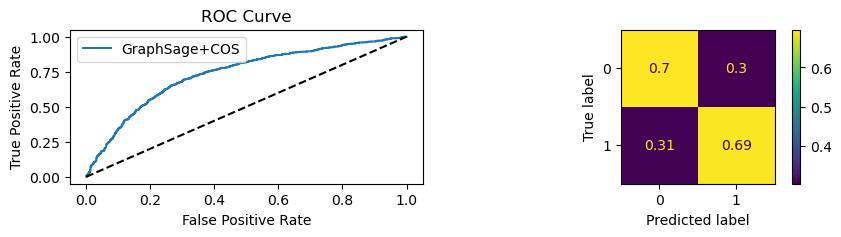

In [124]:
dictionary = evaluate(embed_model ,link_predictor,data_test_embed,data_test_predict,data_sample=data,threshold=0.5,show_extra_metrics=True,return_dict=True)
#torch.save(test_accuracy, 'test_accuracy.pt')

In [127]:
np.save(os.path.join("Saved_models","GraphSage_mixture_lambda_05","GraphSage_epoch_triplet_loss_lambda_05.npy"), dictionary)

In [129]:
 #load_dictionary(file_path):

Custom_loss                    = np.load(os.path.join("Saved_models","GraphSageCosineTripletLoss","GraphSage_epoch_triplet_loss_lambda_09.npy"),allow_pickle=True)
Custom_loss_2                  = np.load(os.path.join("Saved_models","GraphSage_mixture_lambda_05","GraphSage_epoch_triplet_loss_lambda_05.npy"),allow_pickle=True)
LLM_12                         = np.load(os.path.join("Saved_models","LLM","MLP_epoch_12.npy"),allow_pickle=True)
GraphSage_epoch_48_cosine      = np.load(os.path.join("Saved_models","GraphSageCosine","GraphSage_epoch_48.npy"),allow_pickle=True)
LLM_GraphSage_epoch_58_cosine  = np.load(os.path.join("Saved_models","GraphSageCosine","GraphSage_epoch_58.npy"),allow_pickle=True)


In [132]:
values_2_plot = {"GraphSage+BCE+COS":GraphSage_epoch_48_cosine ,"LLM+Graphsage+BCE+COS":LLM_GraphSage_epoch_58_cosine,"LLM+MLP+BCE":LLM_12,"LLM+Graphsage+COS+BCE-TL λ=0.9":Custom_loss,"LLM+Graphsage+COS+BCE-TL λ=0.5": Custom_loss_2     }

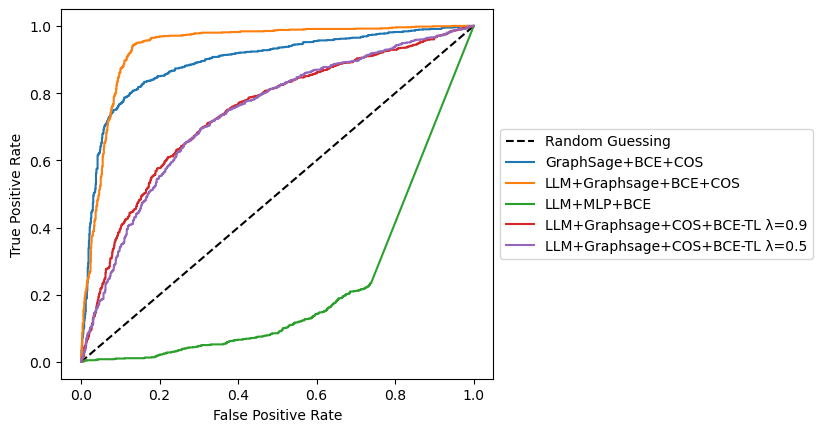

In [133]:
import matplotlib.pyplot as plt

plt.plot([0, 1], [0, 1], 'k--', label="Random Guessing")

for key_, value_ in values_2_plot.items():
    plt.plot(value_.tolist()["FPR"], value_.tolist()["TPR"], label=key_)

plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.subplots_adjust(right=0.8)

plt.show()

In [98]:
pred,labels,head,tail,negative_edge_index = forward_pass(model= embed_model , link_predictor = link_predictor,data_embed = data_train_embed,data_predict = data_train_predict,data_sample = data,return_node_emb=True)
  

In [99]:
Links = head*tail
Links = Links.detach().numpy()


In [100]:
Links

array([[  72.9132   ,  -99.06104  , -102.95317  , ..., -280.76575  ,
         340.59277  ,  176.09372  ],
       [-281.3116   ,   49.36109  , -146.65448  , ...,  162.4761   ,
         313.66797  ,  426.33896  ],
       [  45.470467 ,    5.3023887,  -18.304436 , ...,  119.767685 ,
         109.88851  ,   53.8697   ],
       ...,
       [ 341.56805  , -298.84552  , -778.4778   , ..., -432.56683  ,
         637.836    ,  145.30223  ],
       [ 325.54013  , -368.90738  ,  -57.53946  , ...,   -2.1333663,
         -48.595978 ,  -30.390543 ],
       [ 146.04036  ,  356.8037   , -586.8993   , ...,   54.60039  ,
          12.598609 ,   -2.0860548]], dtype=float32)

In [101]:
Links.shape

(19336, 524)

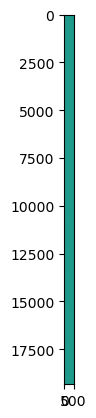

In [102]:
plt.imshow(Links)

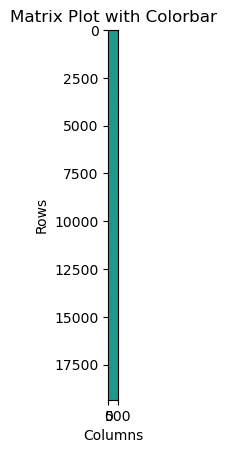

In [118]:
normalized_matrix = (Links- np.min(Links)) / (np.max(Links) - np.min(Links)) 
plt.imshow(normalized_matrix , cmap='viridis')



# Set labels and title
plt.xlabel('Columns')
plt.ylabel('Rows')
plt.title('Matrix Plot with Colorbar')

# Show the plot
plt.show()

In [104]:
negative_edge_index

tensor([[ 3687,  1974,  2117,  ...,  5019,  3064, 14617],
        [ 3075,  2805,  2847,  ...,   331,  3401,   640]])

In [119]:
import umap

In [120]:
# Create a UMAP object and fit the data
reducer   = umap.UMAP()
embedding = reducer.fit_transform(normalized_matrix)

# The embedding variable now contains the low-dimensional vectors
print(embedding.shape)  # Prints 

ValueError: cannot assign slice from input of different size

In [ ]:
embedding.shape

In [121]:
Positive_links 

NameError: name 'Positive_links' is not defined

In [ ]:
Negative_links 

In [ ]:
head.shape

In [ ]:
Positive_links = embedding[0:head.shape[0]//2,:]
Negative_links = embedding[head.shape[0]//2:,:]

In [ ]:
# Plot the positive vector with blue color
plt.scatter(Positive_links[:,0], Positive_links[:,1], color='blue', label='Positive')

# Plot the negative vector with red color
plt.scatter(Negative_links[:,0],Negative_links[:,1], color='red', label='Negative')

# Add labels and legend
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()

# Show the plot
plt.show()

In [ ]:
# Plot the positive vector with blue color
plt.scatter(Positive_links[:,0], Positive_links[:,1], color='blue', label='Positive')

In [ ]:
# Plot the negative vector with red color
plt.scatter(Negative_links[:,0],Negative_links[:,1], color='red', label='Negative')